# Predicting RUL for Turbofan Engines

## Drew Allen

In [1948]:
import sklearn
import random
import math
import numpy as np
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [1949]:
 def evaluate(model,y_pred):
    print("Score on Train:",model.score(train_features,train_labels).round(decimals=2))
    print("Score on Test:",model.score(test_features,test_labels).round(decimals=2))
    print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, y_pred).round(decimals=2))  
    print('Mean Squared Error:', metrics.mean_squared_error(test_labels, y_pred).round(decimals=2))  
    mse = metrics.mean_squared_error(test_labels, y_pred).round(decimals=2)
    print('RSME:', math.sqrt(mse))

In [1950]:
def line_predict(y_pred):
    plt.rcParams["figure.figsize"] = (13,8)

    x = []

    for i in range(100):
        x.append(i)

    plt.plot(x, y_pred, color="orange")
    plt.plot(x, test_labels, color="blue")
    plt.xlabel('Engine #', fontsize = 18)
    plt.ylabel('RUL in Cycles', fontsize = 18)

    y1 = y_pred
    y2 = test_labels

    plt.plot(x, y_pred, "orange", label="Predicted")
    plt.plot(x, test_labels, "blue", label="True")
    plt.legend(loc="upper left",fontsize="18")

    plt.show()

In [1951]:
def sensor_display(sensor):
    x = train['RUL']
    y = train[sensor]

    plt.plot(x, y, 'o')
    plt.gca().invert_xaxis()

    m, b = np.polyfit(x, y, 1)

    plt.plot(x, m*x+b)

In [1952]:
index_names = ['engine', 'cycle']
setting_names = ['set_1', 'set_2', 'set_3']
sensor_names = ['sen_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

In [1953]:
pd.set_option('max_columns', None)
pd.options.mode.chained_assignment = None

In [1954]:
#Reading in the train & test data / the RUL file (test labels)

train = pd.read_csv('train_FD001.txt', sep='\s+', header=None,names=col_names)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None,names=col_names)
test_RUL = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None)

#Test_final is an empty dataframe that will hold the finalized test data

test_final = pd.DataFrame(columns=col_names)

In [1955]:
print("Train shape:",train.shape)
print("Test shape:",test.shape)
print("Test Labels shape:",test_RUL.shape)

Train shape: (20631, 26)
Test shape: (13096, 26)
Test Labels shape: (100, 1)


## Creating an RUL column for the training data to act as train labels for model fitting

In [1956]:
#Each row is assigned an RUL value (max engine cycle - current cycle)

train_labels = []

for i in range(100):
    engine = train.loc[train['engine']==i+1]
    max = len(engine)
    cycles = engine.cycle.to_numpy()
    for j in range(max):
        RUL = max - cycles[j]
        train_labels.append(RUL)
        
train['RUL'] = train_labels

In [1957]:
#Train Labels (RUL column) same shape as train data

print("Train Labels shape:",train['RUL'].shape)

Train Labels shape: (20631,)


In [1958]:
#Showing the new RUL column in relation to cycles

print(train[['engine','cycle','RUL']].head(192))

     engine  cycle  RUL
0         1      1  191
1         1      2  190
2         1      3  189
3         1      4  188
4         1      5  187
..      ...    ...  ...
187       1    188    4
188       1    189    3
189       1    190    2
190       1    191    1
191       1    192    0

[192 rows x 3 columns]


In [1959]:
res = train.groupby('engine')['RUL'].max().reset_index()
print("Training data:\n")
print("Avg cycles before failure:",res['RUL'].mean())
print("Max cycles before failure:",res['RUL'].max())
print("Min cycles before failure:",res['RUL'].min())

Training data:

Avg cycles before failure: 205.31
Max cycles before failure: 361
Min cycles before failure: 127


<AxesSubplot:>

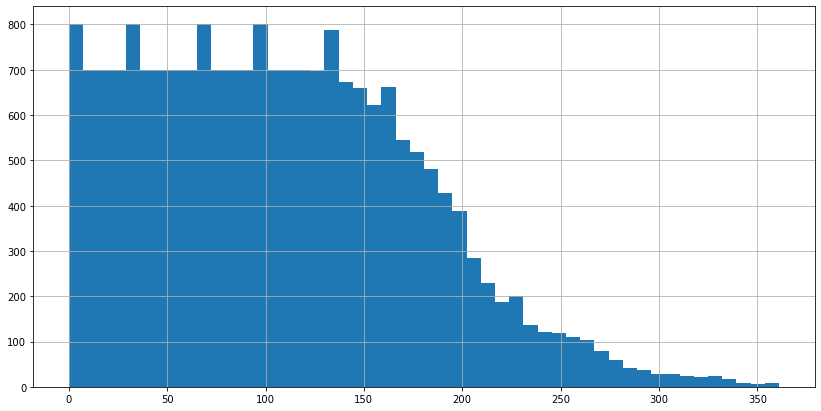

In [1960]:
train['RUL'].hist(bins=50,figsize=(14,7))

Text(0, 0.5, 'Frequency')

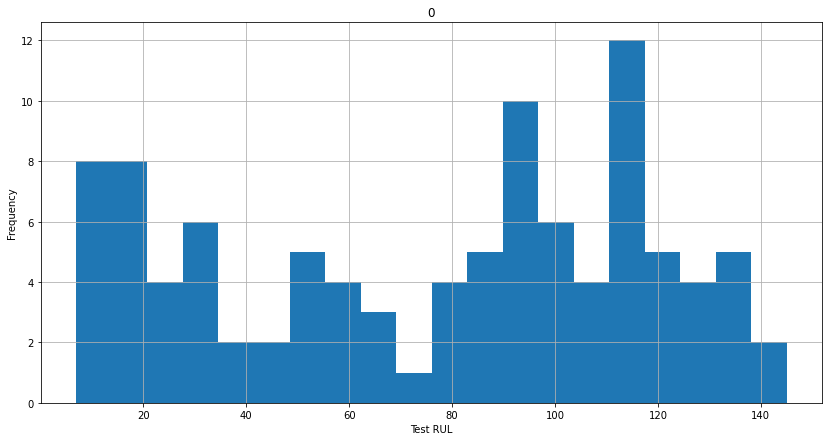

In [1961]:
test_RUL.hist(bins=20,figsize=(14,7))
plt.xlabel("Test RUL")
plt.ylabel("Frequency")

## Finalizing the test data to match shape the of the test labels

## Row containing final given cycle for each engine is added to new DataFrame

In [1962]:
for i in range(100):
    engine = test.loc[test['engine']==i+1]
    df = pd.DataFrame(engine)
    max = len(engine)
    test_final = test_final.append(df.iloc[[max-1]])
    
print("Shape of original test data:",test.shape)
print("Shape of provided test labels:",test_RUL.shape)
print("Shape of finalized test data:",test_final.shape)

Shape of original test data: (13096, 26)
Shape of provided test labels: (100, 1)
Shape of finalized test data: (100, 26)


## Distribution of Max Cycles of Training Engines

### Several high-end outliers exist

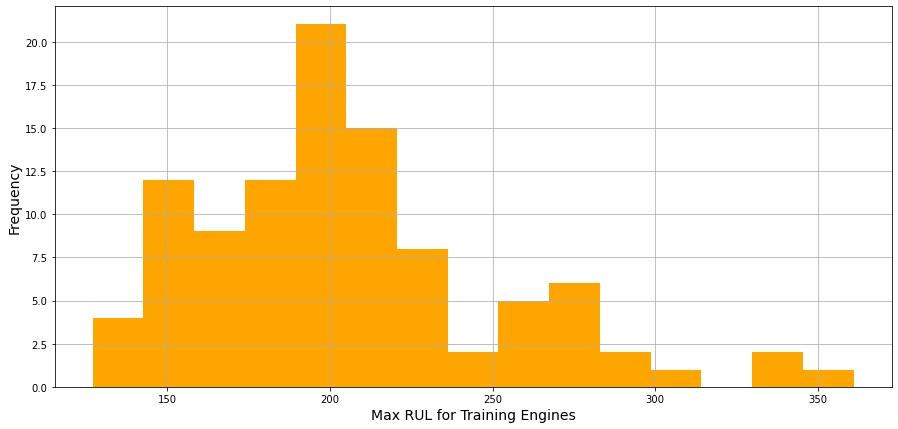

In [1963]:
max_rul = train[['engine', 'RUL']].groupby('engine').max().reset_index()
max_rul['RUL'].hist(color = "orange",bins=15, figsize=(15,7))
plt.xlabel('Max RUL for Training Engines', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

<AxesSubplot:>

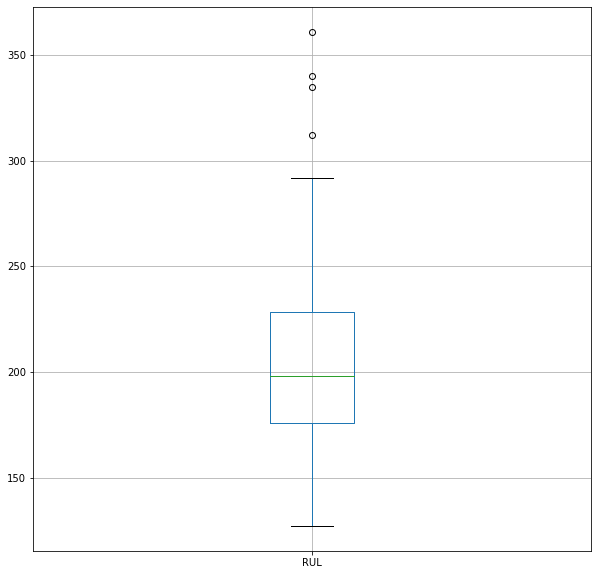

In [1964]:
boxframe = pd.DataFrame()
boxframe['RUL'] = max_rul['RUL']
boxframe.boxplot(figsize=(10,10))

## Taking a look at the tendencies for setting & sensor readings

In [1965]:
#Describe() method for all column names

for i in col_names:
    print(train[i].describe())
    print()

count    20631.000000
mean        51.506568
std         29.227633
min          1.000000
25%         26.000000
50%         52.000000
75%         77.000000
max        100.000000
Name: engine, dtype: float64

count    20631.000000
mean       108.807862
std         68.880990
min          1.000000
25%         52.000000
50%        104.000000
75%        156.000000
max        362.000000
Name: cycle, dtype: float64

count    20631.000000
mean        -0.000009
std          0.002187
min         -0.008700
25%         -0.001500
50%          0.000000
75%          0.001500
max          0.008700
Name: set_1, dtype: float64

count    20631.000000
mean         0.000002
std          0.000293
min         -0.000600
25%         -0.000200
50%          0.000000
75%          0.000300
max          0.000600
Name: set_2, dtype: float64

count    20631.0
mean       100.0
std          0.0
min        100.0
25%        100.0
50%        100.0
75%        100.0
max        100.0
Name: set_3, dtype: float64

count    2.063

C:\Users\drews\AppData\Local\Temp/ipykernel_19612/341745360.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


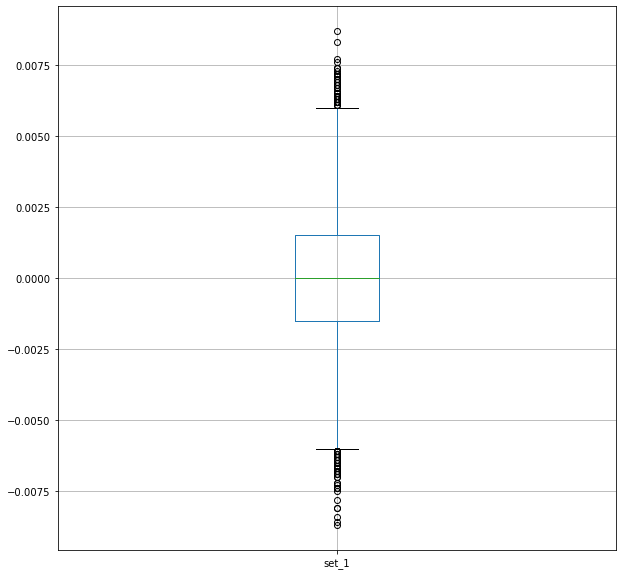

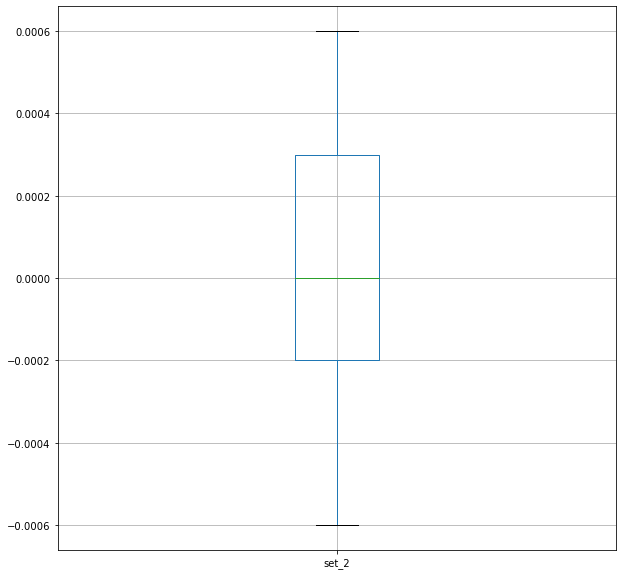

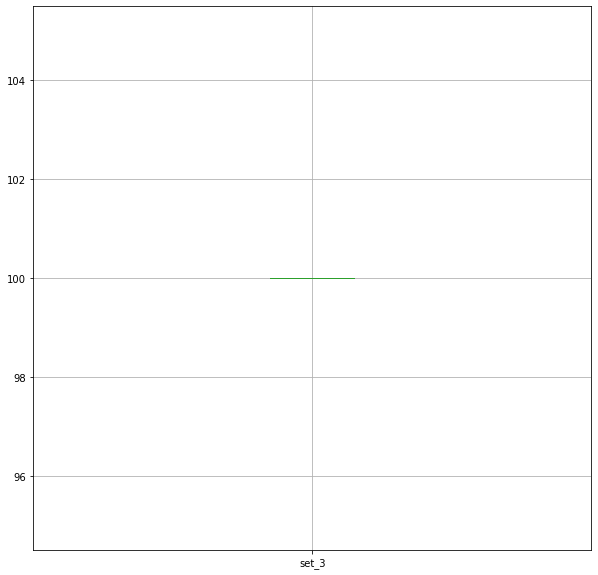

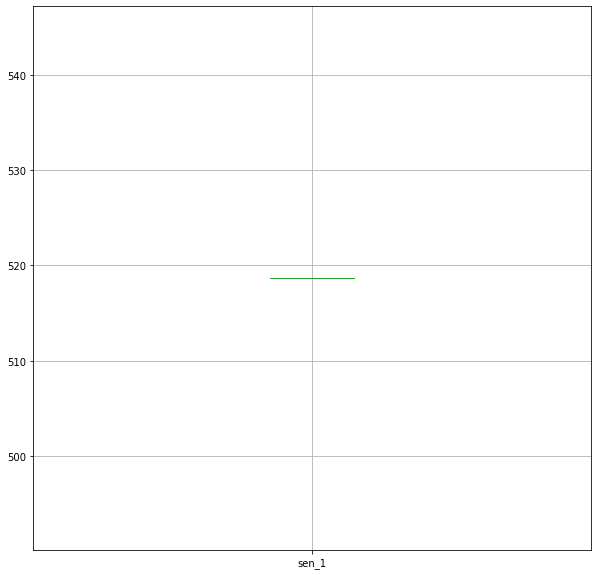

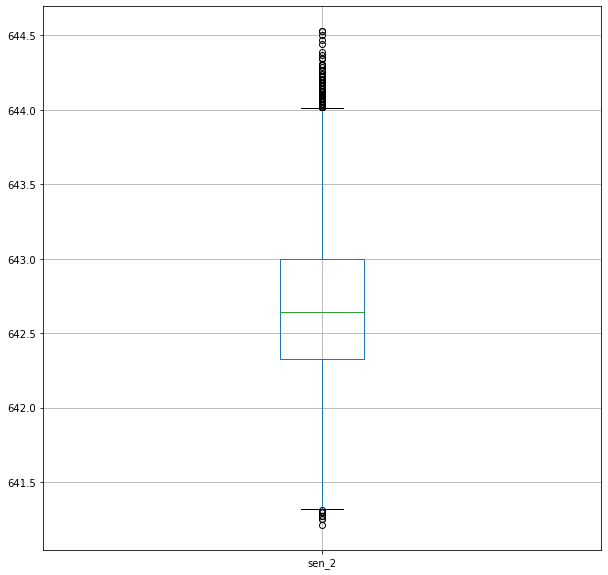

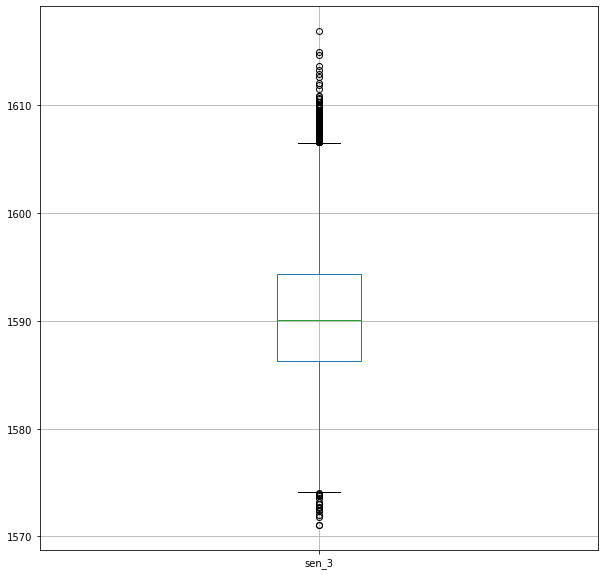

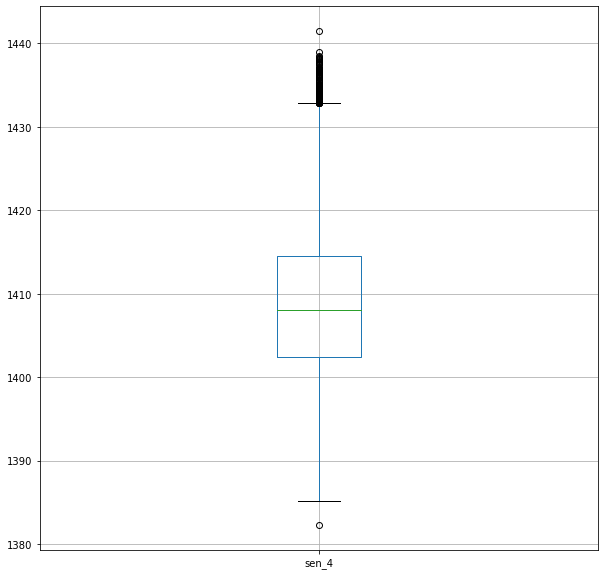

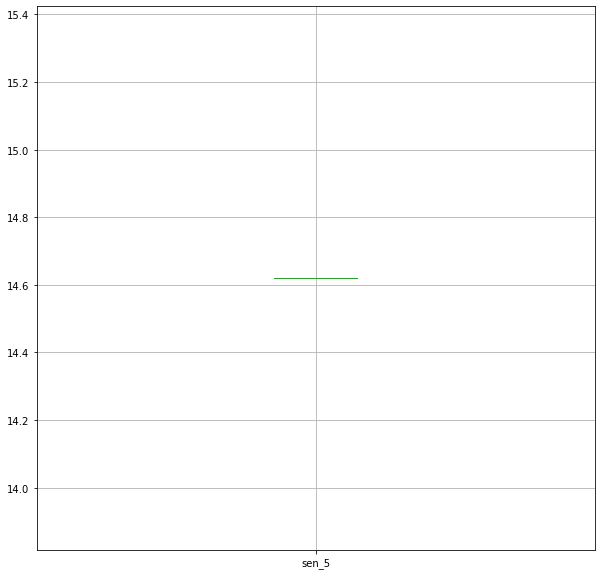

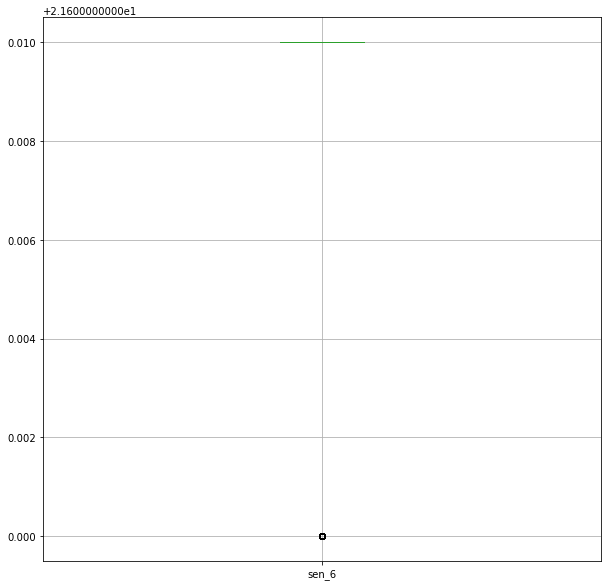

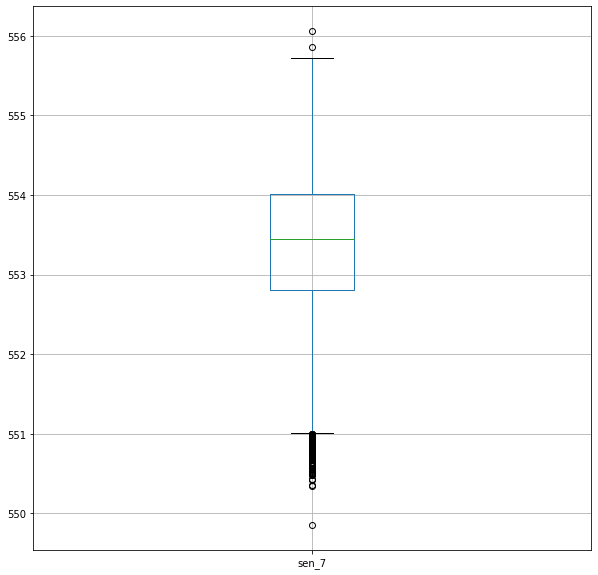

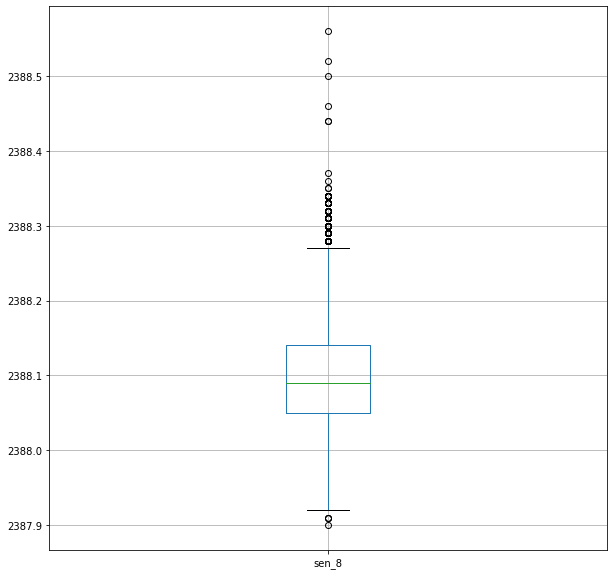

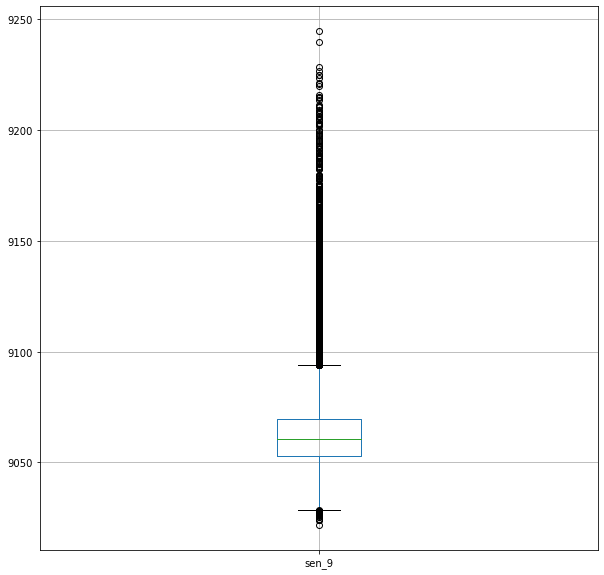

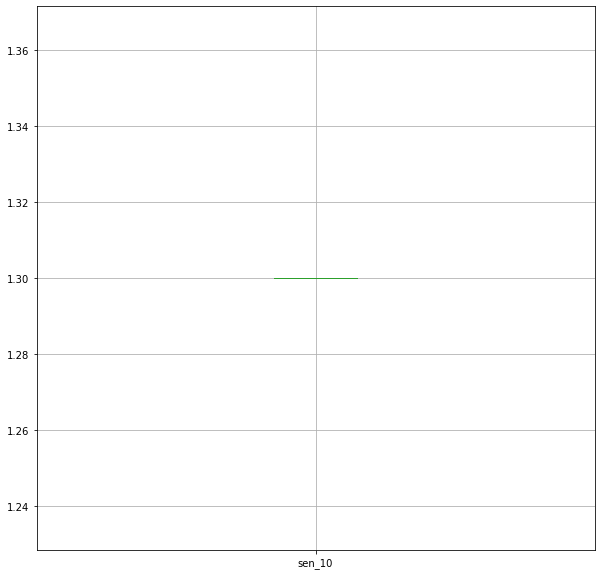

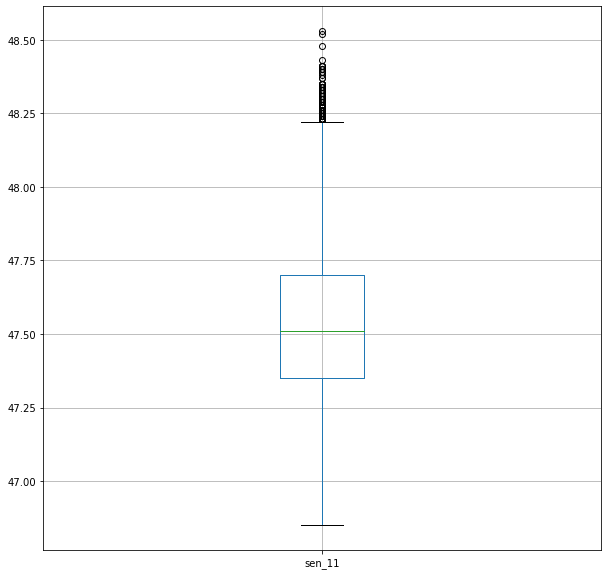

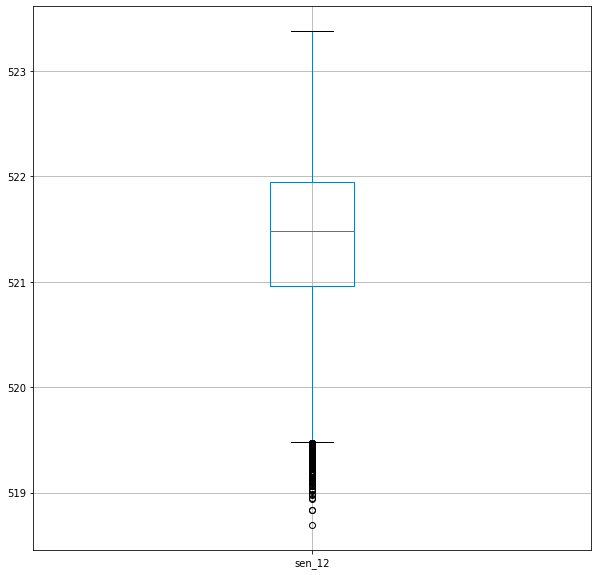

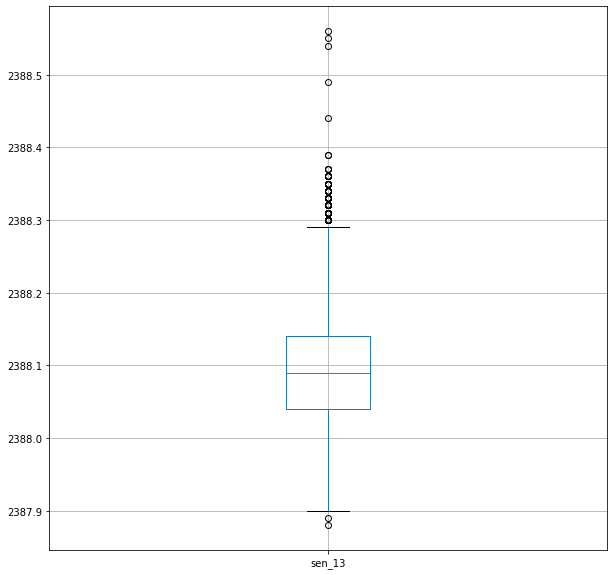

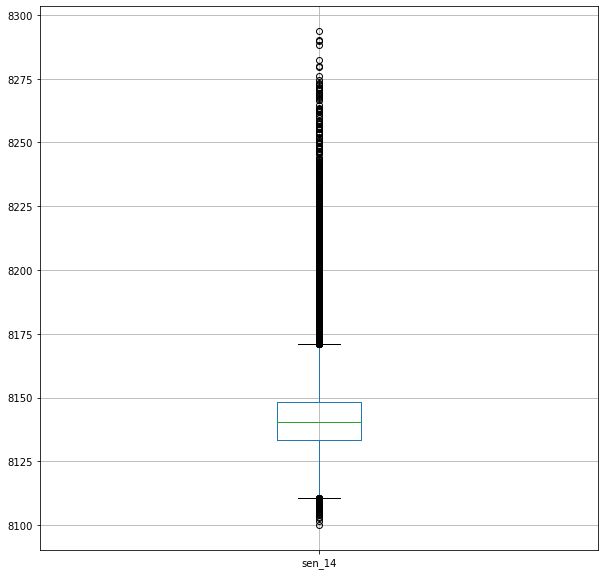

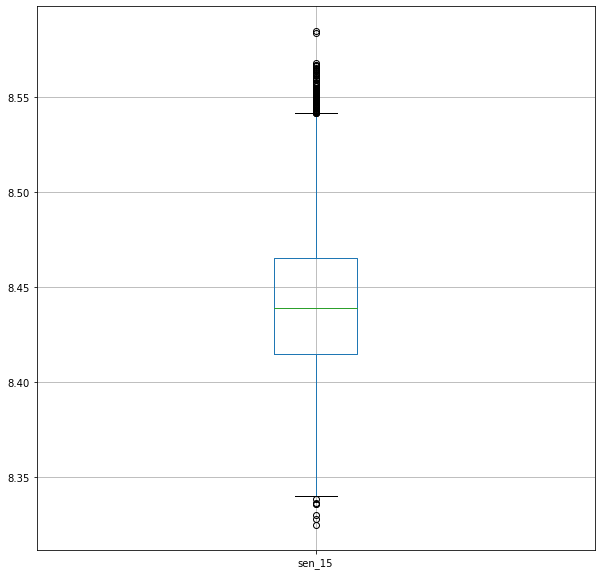

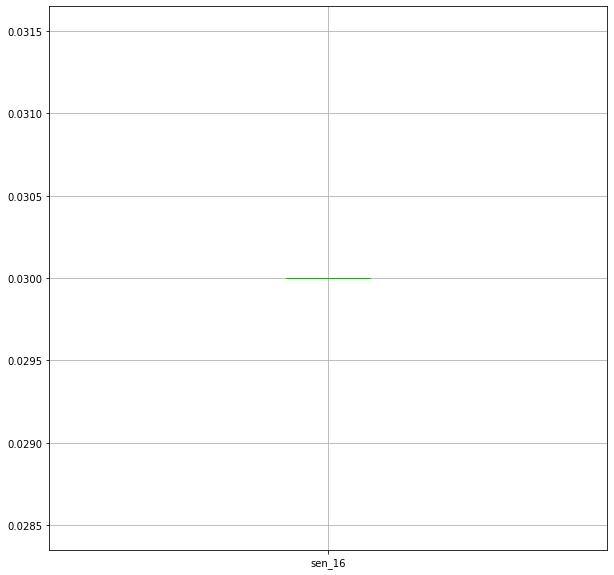

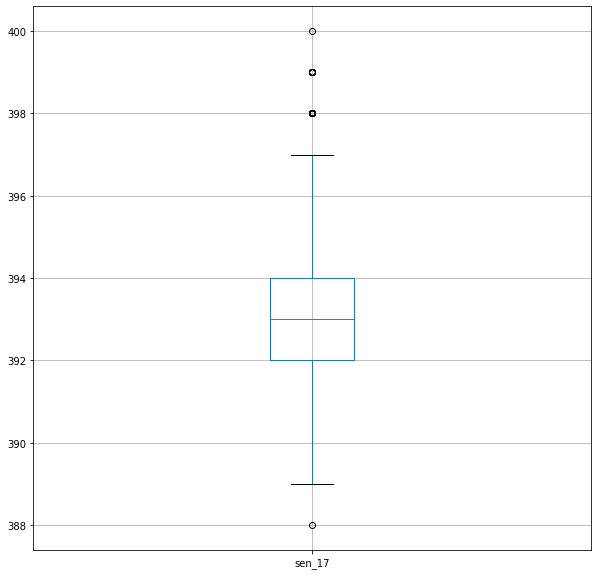

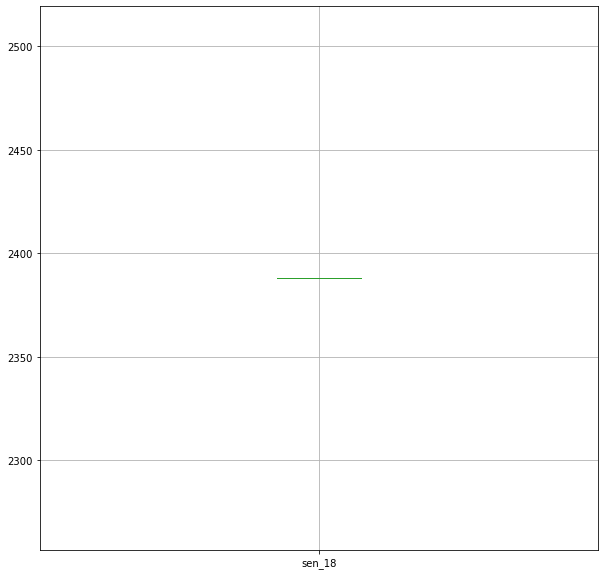

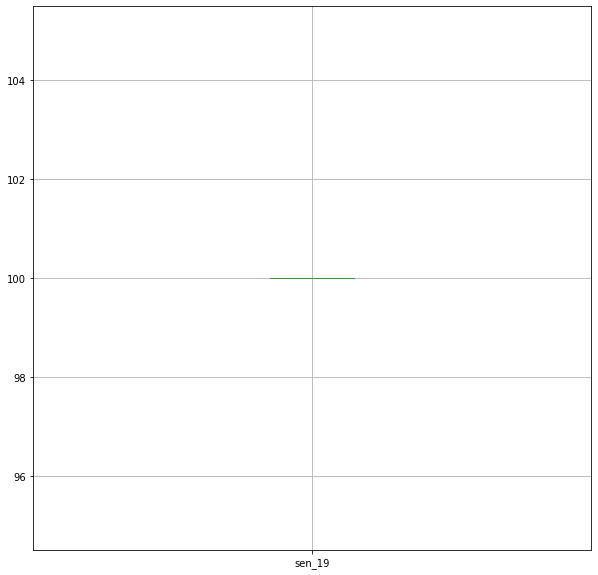

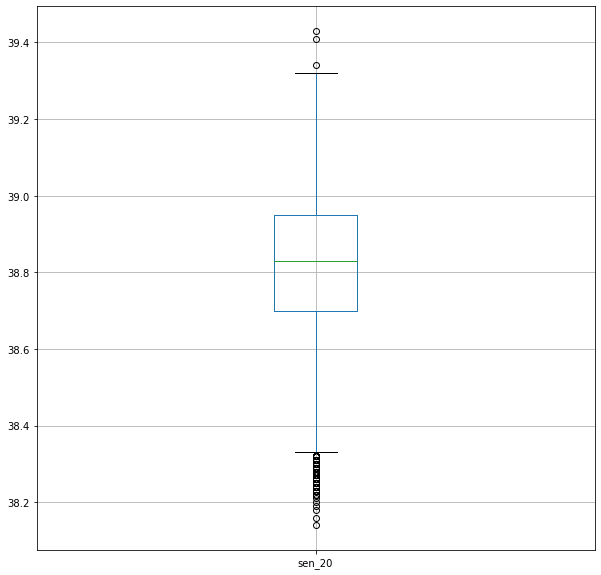

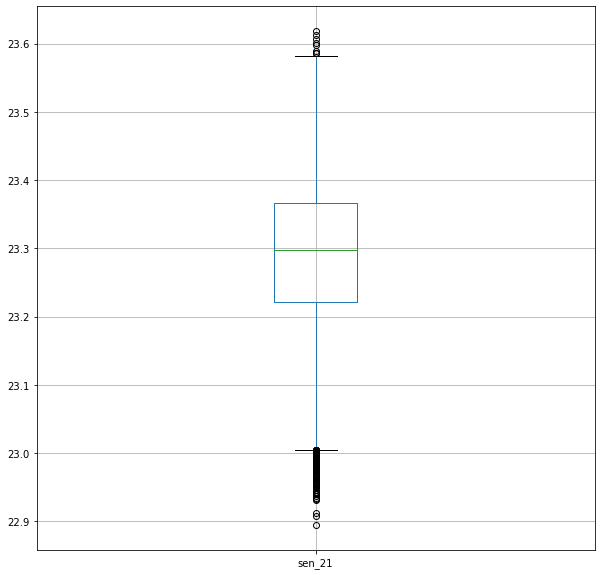

In [1966]:
box_cols = train.drop(['engine','cycle','RUL'],axis=1)

for column in box_cols:
    x = train['RUL']
    y = train[column]

    plt.figure(figsize=(10,10))
    box_cols.boxplot([column])

## Taking a random sample of 7500 rows for model training

In [1967]:
#Creating a new dataframe of random rows for specified amount to limit the training size.

train_revised = pd.DataFrame()
    
for i in range(7500):
    index = random.randint(0,len(train)-1)
    train_revised = train_revised.append(train.iloc[[index]])

## Dropping several features from the training set based upon constant means / standard deviations

In [1968]:
train_features = train_revised.drop(['RUL','engine','sen_1','sen_5','sen_6','sen_10','sen_16','sen_18','sen_19'], axis=1)
train_labels = train_revised.RUL
test_features = test_final.drop(['engine','sen_1','sen_5','sen_6','sen_10','sen_16','sen_18','sen_19'], axis=1)
test_labels = test_RUL

In [1969]:
lm = LinearRegression()
lm.fit(train_features,train_labels)
linear_pred = lm.predict(test_features)

In [1970]:
evaluate(lm,linear_pred)

Score on Train: 0.66
Score on Test: 0.44
Mean Absolute Error: 25.77
Mean Squared Error: 971.39
RSME: 31.16713012133135


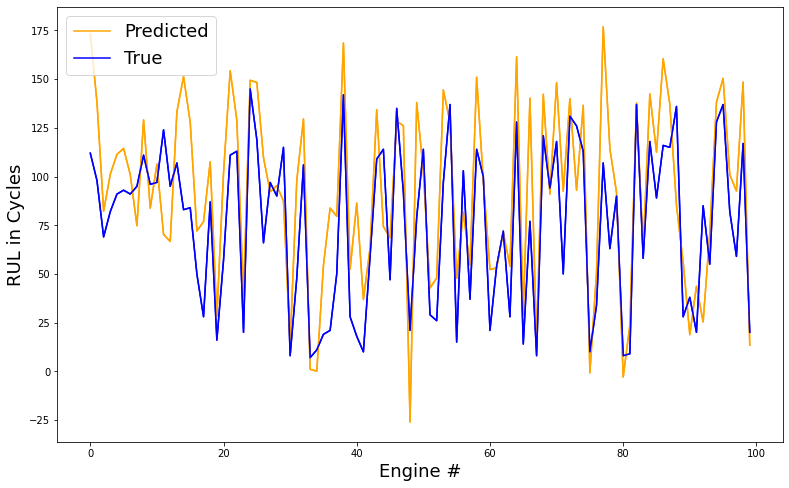

In [1971]:
line_predict(linear_pred)

In [1972]:
rf1 = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=10)
rf1.fit(train_features,train_labels)
rf_pred = rf1.predict(test_features)

In [1973]:
evaluate(rf1,rf_pred)

Score on Train: 0.97
Score on Test: 0.58
Mean Absolute Error: 20.06
Mean Squared Error: 725.58
RSME: 26.93659221208206


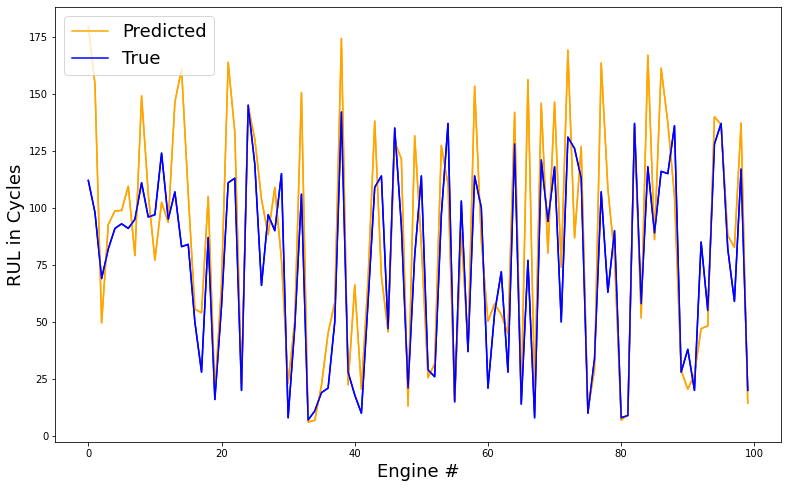

In [1974]:
line_predict(rf_pred)

## Sample of sensor measurement distributions

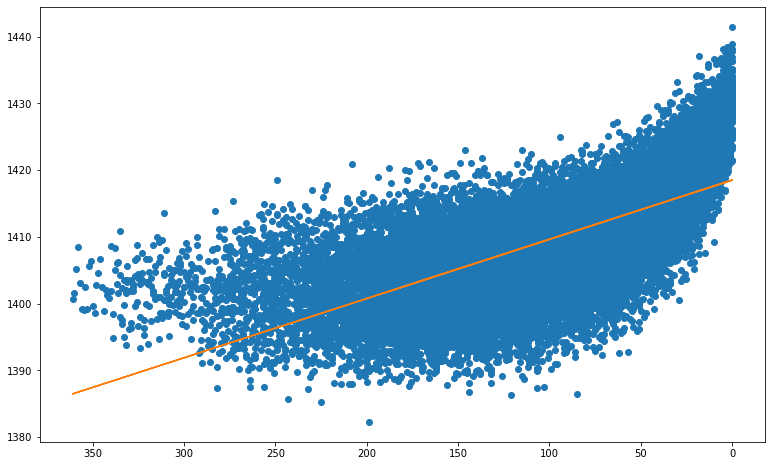

In [1975]:
sensor_display('sen_4')

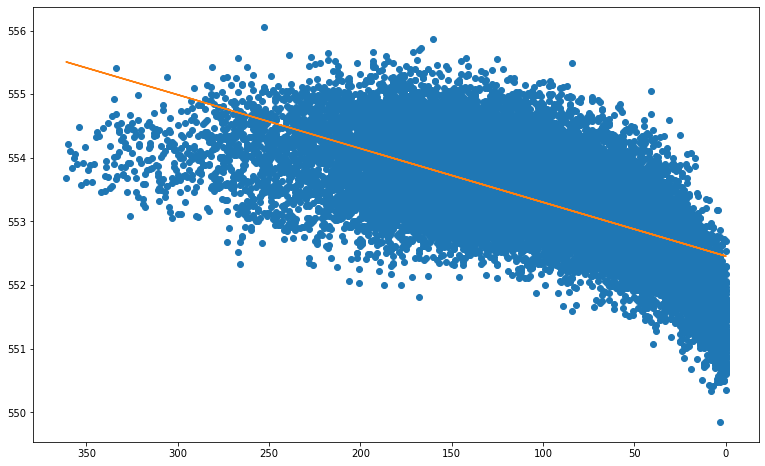

In [1976]:
sensor_display('sen_7')

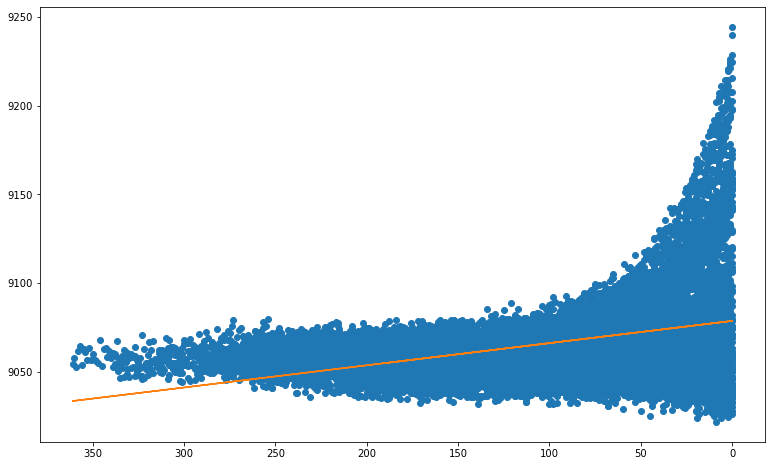

In [1977]:
sensor_display('sen_9')

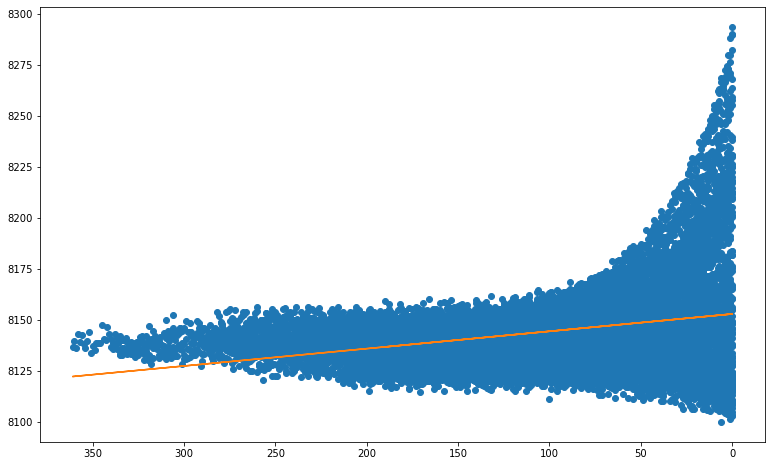

In [1978]:
sensor_display('sen_14')

### As seen above, the initial Regression & RandomForest models score relatively poorly in several metrics. Observing sensor readings throughout engine life cycle shows that sensor readings remain relatively constant until about 150 to 100 cycles are remaining. It has been found that clipping the upper bound of our training labels allows us to work past the large of amount of ~constant sensor readings from earlier in the engine's life.

In [1979]:
train_clipped = train_labels.clip(upper=125)

In [1980]:
lm2 = LinearRegression()
lm2.fit(train_features,train_clipped)
lm2_pred = lm2.predict(test_features)

In [1981]:
evaluate(lm2,lm2_pred)

Score on Train: 0.48
Score on Test: 0.71
Mean Absolute Error: 17.6
Mean Squared Error: 497.37
RSME: 22.30179364983902


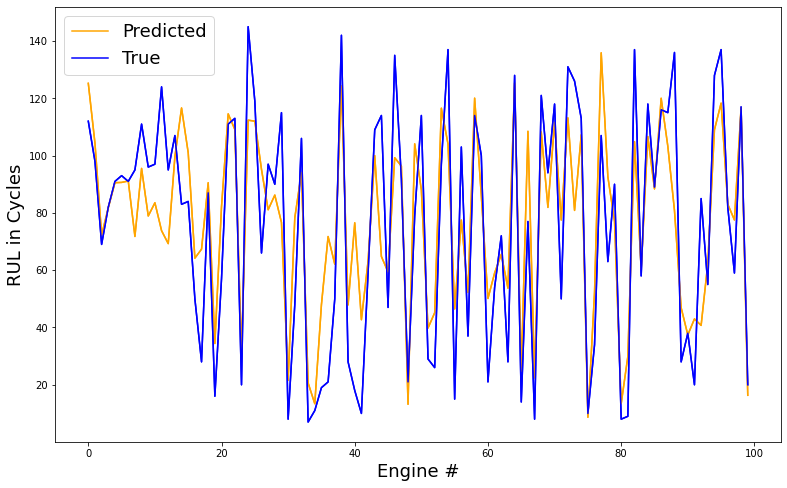

In [1982]:
line_predict(lm2_pred)

In [1983]:
rf2 = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=10)
rf2.fit(train_features,train_clipped)
rf2_pred = rf2.predict(test_features)

In [1984]:
evaluate(rf2,rf2_pred)

Score on Train: 0.59
Score on Test: 0.81
Mean Absolute Error: 13.4
Mean Squared Error: 322.47
RSME: 17.95744970757262


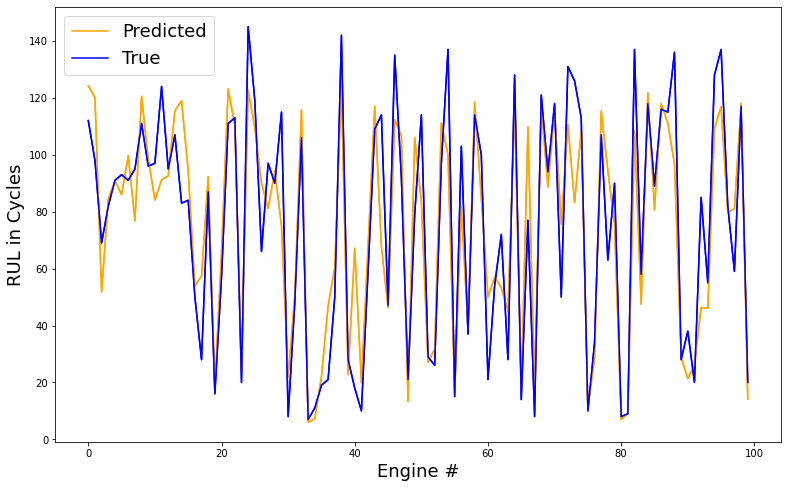

In [1986]:
line_predict(rf2_pred)

## Note: The clipped models score worse on training data than test data, likely because we have altered the real RUL values for a good portion of the original training data that included data points early in the engine's life. The test data is unclipped and was taken randomly, therefore inherently closer to the failure cycle than a majority of training points.